In [10]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [11]:
cd /gdrive/My\ Drive//

/gdrive/My Drive


In [12]:
!pip install git+https://github.com/vafaei-ar/ccgpack.git

  Cloning https://github.com/vafaei-ar/ccgpack.git to /tmp/pip-req-build-f1vnr_dl
  Running command git clone -q https://github.com/vafaei-ar/ccgpack.git /tmp/pip-req-build-f1vnr_dl


In [13]:
!pip install healpy

In [14]:
import matplotlib as mpl
import os
import sys
import shutil
import argparse
import numpy as np
import pylab as plt
import healpy as hp
from ccgpack import sky2patch,ch_mkdir,pop_percent,download

In [15]:
parser = argparse.ArgumentParser(description='Short sample app')
parser.add_argument('-r', action="store_true", default=True)

args = parser.parse_args(args=[])
replace = args.r

In [16]:
cmap = plt.cm.jet
cmap.set_under('w')
cmap.set_bad('gray',1.)

n_gaussian = 50
nside = 2048
lmax = 3*nside
fwhm = 0.9 
fwhm = np.radians(fwhm/60.)
path = './data/cmb_s4ii/'
dest = './data/s4_patch/'


cl = np.load('./cl_planck_lensed.npy')
ll = cl[:lmax,0]
cl = cl[:lmax,1]
cl = np.concatenate([[0,0] , cl])
ll = np.concatenate([[0,1] , ll])

ch_mkdir(path)

In [17]:
def kelvin_check(m):
    if m.std()>1e-2:
        return 1e-6*m
    return m

def build_map(inmap,output,i,
                ntot = None,
                ns = 1,
                kelvin = 0,
                sml = 0.,
                lmax = 3*2048,
                prefix = ''):    
    ch_mkdir(dest)
    dont = 1
    npatch = 12*ns**2
    for j in range(npatch):
        if not os.path.exists(output+prefix+str(i*npatch+j)+'.npy'):
            dont = 0
    if dont:
        return
    
    s = hp.read_map(inmap,nest=1,verbose=0)

    if kelvin:
        s = kelvin_check(s)

    patches = sky2patch(s,ns)

    for j in range(npatch):
        if not ntot is None:
            pop_percent(i*npatch+j,ntot*npatch)
        np.save(output+prefix+str(i*npatch+j),patches[j])
        plt.imshow(patches[j], cmap=cmap)
        plt.savefig(output+prefix+str(i*npatch+j)+'.jpg')
        plt.close() 

Simulation gaussian healpix map: 0


setting the output map dtype to [dtype('float64')]


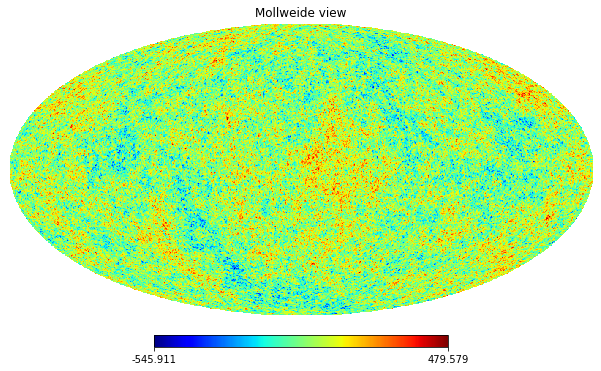

20.0% completemap 0 done
Simulation gaussian healpix map: 1


setting the output map dtype to [dtype('float64')]


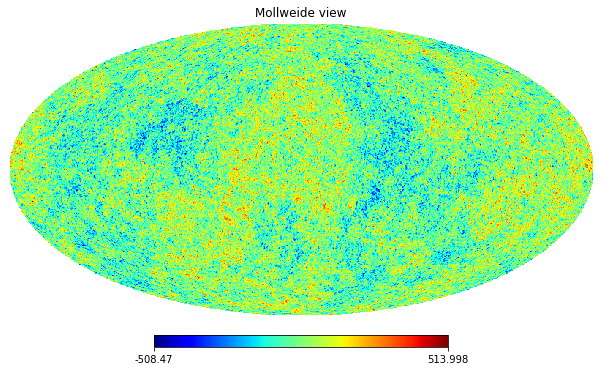

40.0% completemap 1 done
Simulation gaussian healpix map: 2


setting the output map dtype to [dtype('float64')]


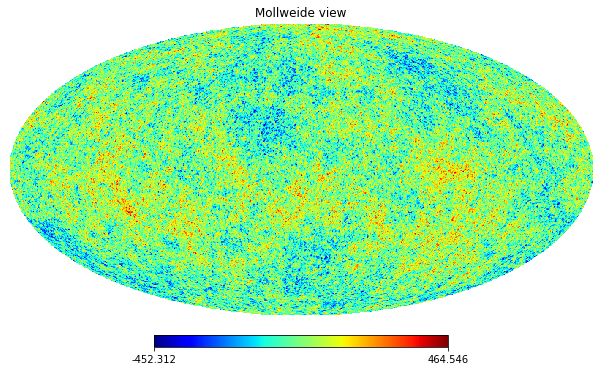

60.0% completemap 2 done
Simulation gaussian healpix map: 3


setting the output map dtype to [dtype('float64')]


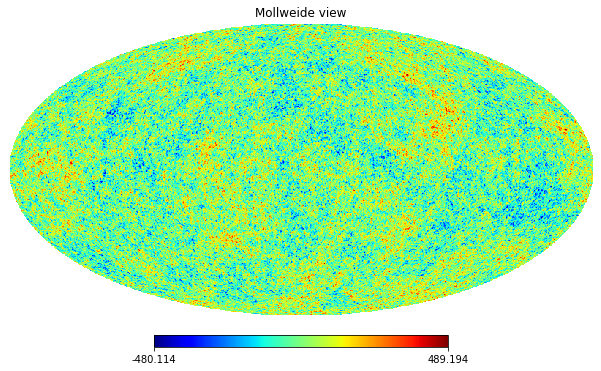

80.0% completemap 3 done
Simulation gaussian healpix map: 4


setting the output map dtype to [dtype('float64')]


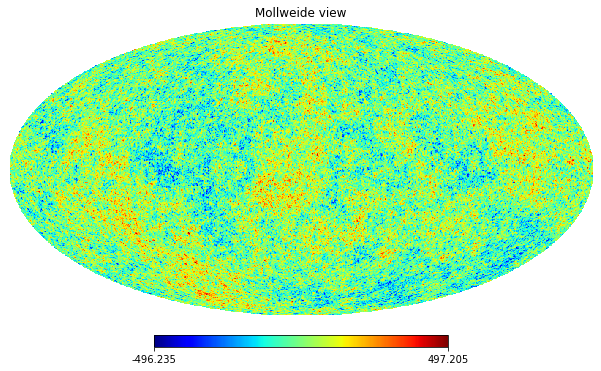

100.0% completed!
map 4 done


In [18]:
n_gaussian = 5

for i in range(n_gaussian):

    if not os.path.exists(path+'map_'+str(nside)+'_'+str(i)+'.fits') or replace:
        print('Simulation gaussian healpix map: '+str(i))

        m,alms = hp.sphtfunc.synfast(cl, nside=nside, fwhm=fwhm , lmax=lmax, mmax=None, alm=True, pol=False, pixwin=False, sigma=None, new=1, verbose=0)
        cl_map = hp.sphtfunc.alm2cl(alms)
        # print(cl_map.shape)

        hp.mollview(m, nest=0, cmap=cmap)
        hp.write_map(path+'map_'+str(nside)+'_'+str(i)+'.fits', m, overwrite=1)
        plt.savefig(path+'map_'+str(nside)+'_'+str(i)+'.jpg')
        plt.show()
        plt.close()
            
        plt.figure(figsize=(10,6))
        dl1 = []
        dl2 = []
        for j in range(ll.shape[0]-1):
                dl1.append(ll[j]*(ll[j]+1)*cl[j]/(2*np.pi))
                dl2.append(ll[j]*(ll[j]+1)*cl_map[j]/(2*np.pi))

        plt.plot(ll[:-1],dl2,'r--',label='Simulation')
        plt.plot(ll[:-1],dl1,'b--',lw=2,label='Orginal')
        plt.xscale('log')
        plt.yscale('log')
        plt.tick_params(labelsize=15)
        plt.xlabel(r'$\ell$',fontsize=25)
        plt.ylabel(r'$D_{\ell}$',fontsize=25)

        plt.legend(loc='best',fontsize=20)
        plt.savefig(path+'power_'+str(nside)+'_'+str(i)+'.jpg')
        plt.close()   

    inmap = path+'map_'+str(nside)+'_'+str(i)+'.fits'
    build_map(inmap,dest,i,n_gaussian , kelvin=1)
    print('map '+str(i)+' done')
    # os.remove(inmap)
    # print('map '+str(i)+' removed!')